In [87]:
import pandas as pd
import datetime as dt
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt 
import functools
from tqdm import tqdm
import quandl
import statsmodels.regression.linear_model as linreg
import requests
from statsmodels.tsa.arima.model import ARIMA
import warnings
import statsmodels.regression.linear_model as linreg
# Suppress the warning
warnings.filterwarnings("ignore")
@functools.lru_cache()
def fetch_quandl_table(table, begin_date = None, end_date = None):
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      # qopts = {"columns":["date", "adj_close"]},
                      # ticker = ticker,
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      paginate=True)
    return qdata

@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None, api_key = 'bXgDCzJUfS5ZxasswLcN'):
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      api_key= api_key,
                      paginate=True)
    return qdata

@functools.lru_cache()
def fetch_options_price(option, date = '2014-01-01', end_date = '2022-12-31'):
    data_url = f'https://api.polygon.io/v1/open-close/{option}/{date}?adjusted=true&apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = f'https://api.polygon.io/v3/snapshot/options/{ticker}?apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = data_url + f'&expiration_data.gte={begin_date}'
    # data_url = data_url + f'&expiration_data.lte={end_date}'
    response = requests.get(data_url)
    if response.status_code == 200:
        return response.json()
    else:
        return response.status_code

# Get VIX close (this will be Y in our regression)

VIX_data = pd.read_csv('/Users/tmac/Downloads/VIX_History.csv')
VIX_data['DATE'] = pd.to_datetime(VIX_data['DATE'])
VIX_data = VIX_data[VIX_data['DATE'] > '2013-12-31'].set_index('DATE').drop(columns=['OPEN', 'HIGH', 'LOW']).rename(columns={'CLOSE': 'VIX'})
VIX_data = VIX_data[VIX_data.index < '2023-01-01']

# Grab (and filter) event data from FxStreet

event_data = pd.read_csv('/Users/tmac/Downloads/Economic Events.csv')
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

# Set event column to True if there's an event, False otherwise

idx = pd.date_range('2014-01-01', '2022-12-31')
VIX_data = VIX_data.reindex(idx, fill_value=None)
VIX_data['Event'] = np.where(VIX_data.index.isin(event_data.index.values), True, False)
VIX_data['Days until Event'] = np.where(VIX_data['Event'] == True, 0, VIX_data.groupby((VIX_data['Event'] == True).cumsum()).cumcount(ascending=False)+1)


# TODO: do we want weekends? remove this if so, and change fill_value above to .ffill()
VIX_data = VIX_data.dropna(subset=['VIX'])

# Grab the VIX data and shift it for regression purposes

VIX_data['VIX Shifted'] = VIX_data['VIX'].shift(1)

# Consumer Sentiment (University of Michigan Consumer Survey, Index of Consumer Sentiment)
# https://data.nasdaq.com/data/UMICH/SOC1-university-of-michigan-consumer-surveyindex-of-consumer-sentiment
# NOTE: this is monthly data, so I forward filled
consumer_sentiment_data = fetch_quandl('UMICH/SOC1', begin_date='2013-12-01', end_date='2022-12-31')
VIX_data['Consumer Sentiment Index'] = consumer_sentiment_data
VIX_data['Consumer Sentiment Index'] = VIX_data['Consumer Sentiment Index'].fillna(method='ffill')
# Fill in the first month with Dec 2013 Index value
VIX_data['Consumer Sentiment Index'] = VIX_data['Consumer Sentiment Index'].fillna(value=consumer_sentiment_data.iloc[0].Index)

# # Fetch Options chain for each expiry day
# options = ['O:SPY221215P00400000', 'O:SPY221215P00350000', 'O:SPY221216P00400000', 'O:SPY221216P00350000']
# dates = pd.date_range('2022-12-01', '2022-12-15')
# dates = [date.strftime('%Y-%m-%d') for date in dates]
# options_price_data = pd.DataFrame(index=pd.date_range('2014-01-01', '2022-12-31'), columns=options)
# for option in options:
#     for date in dates:
#         result = fetch_options_price(option, date=date)
#         if not isinstance(result, int):
#             options_price_data.loc[date, option] = result['close']



In [88]:
VIX_data

,VIX,Event,Days until Event,VIX Shifted,Consumer Sentiment Index
2014-01-02,14.23,False,1,NaN,82.5
2014-01-03,13.76,True,0,14.23,82.5
2014-01-06,13.55,True,0,13.76,82.5
2014-01-07,12.92,False,1,13.55,82.5
2014-01-08,12.87,True,0,12.92,82.5
...,...,...,...,...,...
2022-12-23,20.87,True,0,21.97,56.8
2022-12-27,21.65,False,5,20.87,56.8
2022-12-28,22.14,False,4,21.65,56.8
2022-12-29,21.44,False,3,22.14,56.8


In [89]:
vix_r = VIX_data[['VIX']].pct_change()

In [90]:
spy =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'SPY', api_key = 'uoxc6V3s61czWuHoGLcs',
                    qopts = { 'columns': ['date', 'adj_close', 'volume'] }, 
                    date = { 'gte': '2014-01-01', 'lte': '2023-01-01' }, 
                     paginate=True)
uis =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'UIS', api_key = 'uoxc6V3s61czWuHoGLcs',
                    qopts = { 'columns': ['date', 'adj_close'] }, 
                    date = { 'gte': '2014-01-01', 'lte': '2023-01-01' }, 
                     paginate=True)
uis.index = uis['date']
spy.index = spy['date']
data = pd.merge(spy, uis, left_index=True, right_index=True)

In [91]:
model_data = pd.merge(vix_r, VIX_data[['Days until Event']],  left_index=True, right_index=True)
model_data = pd.merge(model_data, spy, left_index=True, right_index=True)
model_data = pd.merge(model_data, uis, left_index=True, right_index=True)

In [92]:
model_data = model_data[['VIX', 'Days until Event', 'adj_close_x', 'volume', 'adj_close_y']]
model_data = model_data.rename(columns = {'adj_close_x': 'Spy close', 'adj_close_y': 'Uis close'})


In [93]:
model_data['Spy return'] = model_data['Spy close'].pct_change()
model_data['Uis return'] = model_data['Uis close'].pct_change()
model_data = model_data.dropna()

In [94]:
model_data

,VIX,Days until Event,Spy close,volume,Uis close,Spy return,Uis return
2014-01-03,-0.033029,0,154.843559,81390600.0,32.98,-0.000164,0.000303
2014-01-06,-0.015262,0,154.394837,108028200.0,33.45,-0.002898,0.014251
2014-01-07,-0.046494,1,155.343079,86144200.0,33.63,0.006142,0.005381
2014-01-08,-0.003870,0,155.376951,96582300.0,33.55,0.000218,-0.002379
2014-01-09,0.001554,1,155.478545,90683400.0,33.74,0.000654,0.005663
...,...,...,...,...,...,...,...
2022-12-23,-0.050068,0,382.910000,59746044.0,4.58,0.005752,0.008811
2022-12-27,0.037374,5,381.400000,51501821.0,4.63,-0.003943,0.010917
2022-12-28,0.022633,4,376.660000,70801096.0,4.66,-0.012428,0.006479
2022-12-29,-0.031617,3,383.440000,66856256.0,5.19,0.018000,0.113734


In [95]:
y = model_data[['VIX']]
exog = model_data[['Days until Event', 'volume', 'Uis return', 'Spy return']]

In [119]:
x = pd.DataFrame(index = y.iloc[-100:].index, columns = ['prediction'])
for i in tqdm(range(1,100)):
    ARIMAmodel = ARIMA(y.iloc[:-i], order = (1,1,1), exog = exog.iloc[:-i]).fit()
    forecast = ARIMAmodel.forecast(1, exog = exog.iloc[-i])
    x.iloc[-i]['prediction'] = forecast.iloc[0]
x = x.shift(-1)
    

100%|██████████| 99/99 [00:46<00:00,  2.14it/s]


Text(0, 0.5, 'VIX return')

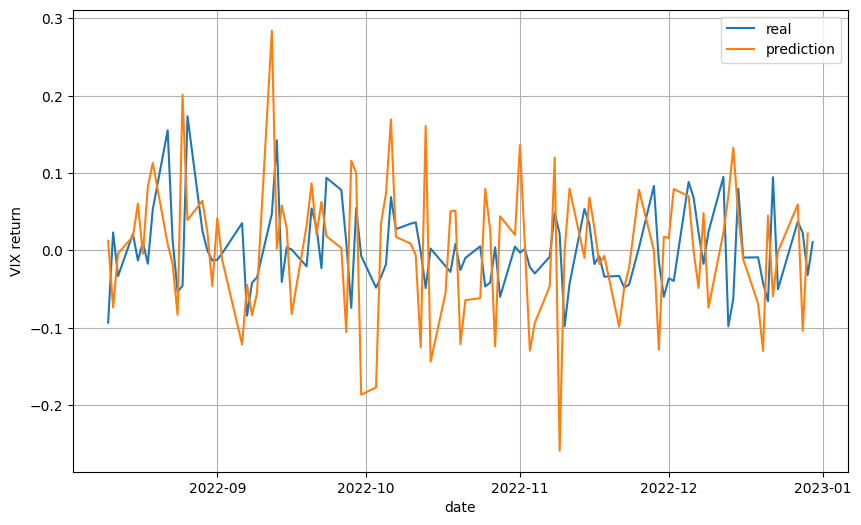

In [121]:
plt.figure(figsize = (10,6))
plt.plot(y.iloc[-100:], label = 'real')
plt.plot(x, label = 'prediction')
plt.grid()
plt.legend()
plt.title = 'Predictions vs Actual for VIX returns'
plt.xlabel('date')
plt.ylabel('VIX return')